<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Optimize-Random-Forest-and-lgbm-benchmarks" data-toc-modified-id="Optimize-Random-Forest-and-lgbm-benchmarks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimize Random Forest and lgbm benchmarks</a></span><ul class="toc-item"><li><span><a href="#Tuned-RF" data-toc-modified-id="Tuned-RF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tuned RF</a></span></li><li><span><a href="#lgbm" data-toc-modified-id="lgbm-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>lgbm</a></span></li></ul></li><li><span><a href="#Out-of-time" data-toc-modified-id="Out-of-time-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Out of time</a></span></li></ul></div>

# GE News - Time Forest Vs Sklearn's Random Forest and LightGBM

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns

from sklearn import metrics
from time import time
from time_tree import TimeSplitTree
from decision_tree import DecisionTree
from sklearn.ensemble import RandomForestClassifier
from models.time_robust_forest import TimeForestClassifier, RandomTimeSplitTree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')

/Users/lgmoneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [48]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [49]:
set_style()

In [7]:
STOP_WORDS = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
CLUB_WORDS = ["verdão", "tricolor", "fla", "timão", "rubro", 
              "negro", "flamengo", "paulo", "palmeirense", "paulista", 
              "inter", "colorado", "internacional", "colorados", "colorada"]
STOP_WORDS += CLUB_WORDS
MAX_VOCABULARY = 300
positive_case = "flamengo"

In [8]:
data = pd.read_csv("~/Documents/datasets/ge_news/data/ge_news.csv", index_col=False)

In [9]:
data.shape

(121949, 6)

In [11]:
def create_different_time_slices(data, time_col="date", aggregation="weekly", n_months=None):
    if aggregation == "daily": return data[time_col].dt.date
    if aggregation == "weekly": return data[time_col].dt.week
    if aggregation == "monthly": return data[time_col].apply(lambda x: x.strftime("%Y-%m"))
    if aggregation == "semester": return False


def exclude_periods_without_positive_case(data, positive_case, period_column, threshold=20):
    df = data.groupby(period_column)["club"].apply(lambda x: np.sum(x == positive_case))
    df = df[df > threshold]
    return data[data[period_column].isin(df.index)]
    
def clean_club_name_from_article(data):
    data["text"] = data.apply(lambda x: x["text"].lower().replace(x["club"].replace("-", " "), ""), axis=1)
    return data

def exclude_numbers(data):
    data["text"] = data["text"].apply(lambda x: ''.join([i for i in x.lower() if not i.isdigit()]))
    return data

def drop_multiple_teams_news(data):
    multiple_team_news = data.groupby("link", as_index=False)["club"].count()
    multiple_team_news = multiple_team_news[multiple_team_news["club"] > 1]["link"]
    return data[~data["link"].isin(multiple_team_news)]


In [12]:
data = clean_club_name_from_article(data)
data = exclude_numbers(data)
data = drop_multiple_teams_news(data)

In [13]:
data.loc[:, "year"] = data["date"].apply(lambda x: x.split("/")[-1])
data.loc[:, "month"] = data["date"].apply(lambda x: x.split("/")[1])
data.loc[:, "date"] = pd.to_datetime(data["date"])

In [14]:
### Monthly context
data["year-month"] = data["year"] + "-" + data["month"]

### Weekly context
data["year-week"] = create_different_time_slices(data)
data["year-week"] = data["year"] + "-" + data["year-week"].astype(str)

In [15]:
data["target"] = data["club"].apply(lambda x: 1 if x == positive_case else 0)

print("The fraction of positive cases is {:.2f}".format(data["target"].mean()))

The fraction of positive cases is 0.09


In [16]:
data = exclude_periods_without_positive_case(data, positive_case, "year-month")

In [17]:
train_end_date = "2018-01"
holdout_end_date = "2020-12"
train_end_year = int(train_end_date.split("-")[0])

In [18]:
in_time = data[data["year-month"] < train_end_date]

train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

out_of_time = data[(data["year-month"] >= train_end_date) & (data["year-month"] <= holdout_end_date)]



In [19]:
target = "target"
time_column = "year-month"
time_column = "year"

In [20]:
print("Dataset shapes:")
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))
print("Out of time: {}".format(out_of_time.shape))

Dataset shapes:
Train: (21062, 11)
Test: (5266, 11)
Out of time: (58332, 11)


In [21]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words=STOP_WORDS,
                             binary=False,
                             use_idf=True,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["text"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["text"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["text"]).toarray(), columns=vectorizer.vocabulary_)

In [22]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [23]:
model = RandomForestClassifier(max_depth=10, n_estimators=25)

In [24]:
model.fit(train_vectors.drop(columns=["year"]), train["target"].values)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [25]:
train["prediction"] = model.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(train[target], train["prediction"])

0.9347653168814303

In [26]:
test["prediction"] = model.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(test[target], test["prediction"])

0.8812474032675272

In [27]:
out_of_time["prediction"] = model.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction"])

0.7806455616535894

## Time Forest

In [28]:
time_model = TimeForestClassifier(n_estimators=60, 
                                  time_column=time_column, 
                                  max_depth=10,
                                  min_sample_periods=10,
                                  max_features=1.0,
                                  n_jobs=4,
                                  multi=True)

time_model.fit(train_vectors, train["target"].values)

#train["time_prediction"] = time_model.predict(train_vectors)
train["time_prediction"] = time_model.predict_proba_(train_vectors)
print(roc_auc_score(train[target], train["time_prediction"]))

test["time_prediction"] = time_model.predict_proba_(test_vectors)
print(roc_auc_score(test[target], test["time_prediction"]))

out_of_time["time_prediction"] = time_model.predict_proba_(oot_vectors)
print(roc_auc_score(out_of_time[target], out_of_time["time_prediction"]))

0.9042243954127364
0.8720717234262126
0.8340997954019361


## Optimize Random Forest and lgbm benchmarks

In [29]:
from pycaret.classification import *

In [30]:
train_features = pd.DataFrame(train_vectors)

In [31]:
features = [col for col in train_features.columns if col != time_column]

In [32]:
train_features

,minutos,tempo,próxima,temporada,atacante,atlético,pr,vai,ano,camisa,após,empate,gols,última,segunda,feira,jogador,chegar,globoesporte,sempre,saída,fluminense,torcedores,desde,momento,arena,deixou,time,paranaense,leia,jogar,aqui,jogadores,abaixo,estar,bom,maior,qualquer,coisa,onde,forma,chegou,sabe,bem,lá,então,melhor,ainda,clube,acho,pode,boa,falta,rio,janeiro,forte,quatro,lugar,entrar,gente,porque,pouco,nada,falar,torcida,torcedor,grande,dois,jogos,campeonato,agora,último,jogo,casa,próximo,domingo,todo,muita,importante,alguns,difícil,ficar,sair,dia,voltar,fim,quase,presidente,menos,deve,ver,vou,coisas,fica,feliz,dar,veja,notícias,esporte,posição,sendo,brasil,decisão,vamos,afirmou,final,copa,sul,clique,ponte,série,brasileiro,grupo,parte,primeira,rodada,corinthians,assim,contra,porém,clássico,diego,elenco,perdeu,anos,quer,seleção,botafogo,vitórias,futebol,gol,volta,vez,deu,duelo,apenas,bola,antes,infelizmente,hoje,conseguiu,fazer,todos,meia,derrota,profissional,técnico,grêmio,nesta,quarta,libertadores,precisa,campeão,desta,ex,título,felipe,técnica,equipe,primeiro,faz,resultado,fez,partida,disse,dentro,campo,cada,adversário,renato,carlos,competição,seis,além,brasileirão,sobre,trabalho,partir,sub,base,treinador,história,sábado,bastante,atleta,segundo,passou,eduardo,neste,atletas,fase,disputa,vaga,disponível,vídeo,desculpe,inconveniente,tarde,santos,sexta,mil,diretoria,carioca,alvinegro,apesar,pedro,silva,enquanto,lado,conteúdo,passado,vitória,estreia,outro,semana,vasco,entrevista,henrique,titular,tudo,confira,outros,clubes,contrato,milhões,dá,três,volante,lucas,acabou,situação,lateral,direito,outra,frente,zagueiro,vezes,vice,quinta,treino,meio,defesa,dias,esquerdo,chance,início,disso,direita,lesão,mg,goiás,palmeiras,novo,mundo,cinco,cruzeiro,vem,vencer,goleiro,área,brasília,terça,estádio,durante,duas,partidas,diante,sequência,ficou,tabela,ataque,oportunidade,bruno,vila,classificação,pontos,ricardo,oliveira,deste,horário,rodrigo,gaúcho,caso,marcou,principal,gabriel,sido,maracanã,acordo,conta,possível,coxa,real,marcelo,nova,rafael,furacão,léo,thiago,últimos,year
0,3.167476,0.0,3.258606,0.000000,0.000000,0.000000,4.717429,6.768603,2.933032,0.0,0.000000,12.293279,0.000000,0.000000,0.000000,0.0,3.807388,11.588169,2.528442,0.000000,4.511517,0.0,0.00000,0.000000,17.722052,0.00000,0.0,6.576474,2.680152,0.000000,7.868895,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.011433,1.880409,0.0000,0.000000,0.0,0.000000,2.486220,0.0,0.0,3.224659,2.650778,0.000000,0.0,0.000000,1.781493,0.0,0.000000,6.917242,6.801877,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.784805,0.000000,0.0,3.075982,0.000000,0.00000,0.000000,2.493381,0.000000,0.000000,0.000000,2.698147,4.345594,0.000000,0.0,0.000000,6.128633,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.918691,2.189191,0.0,0.000000,0.00000,0.0,0.000000,0.000000,2.778038,0.0,3.277873,0.000000,2.981773,0.000000,2.586812,0.000000,5.776248,0.000000,0.000000,0.000000,6.849586,6.414489,0.0,0.000000,0.000000,1.568126,0.000000,3.418376,0.000000,3.26316,2.948239,0.000000,2.520592,0.000000,13.28181,3.00055,3.270030,0.0,0.000000,0.000000,0.0,0.0,5.060829,6.609498,0.0,0.000000,0.000000,2.261777,4.845989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.612499,0.000000,0.000000,0.000000,6.216584,9.817310,2.012028,2.430112,3.148356,5.936654,0.0,0.000000,2.959293,0.000000,0.000000,0.000000,3.065814,9.439632,0.000000,2.800486,0.0,0.000000,0.0,0.000000,0.000000,2.395787,2.812337,0.0,0.0,0.000000,2.781698,4.926385,3.166233,0.0,12.591053,0.000000,0.000000,2.433889,0.000000,0.000000,0.000000,9.052624,0.0,0.000000,0.0,0.0,0.000000,6.604506,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,4.518195,0.000000,0.000000,7.784903,0.000000,0.000000,0.000000,10.570589,22.282965,0.000000,5.88386,0.000000,0.000000,0.000000,0.000000,2.804228,2.585189,6.512674,0.000000,3.289989,2.534151,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.704653,

In [33]:
train_data_opt = train_features.copy(deep=True)
train_data_opt[target] = train[target].values

In [34]:
train_data_opt.shape

(21062, 302)

In [35]:
train_data_opt

,minutos,tempo,próxima,temporada,atacante,atlético,pr,vai,ano,camisa,após,empate,gols,última,segunda,feira,jogador,chegar,globoesporte,sempre,saída,fluminense,torcedores,desde,momento,arena,deixou,time,paranaense,leia,jogar,aqui,jogadores,abaixo,estar,bom,maior,qualquer,coisa,onde,forma,chegou,sabe,bem,lá,então,melhor,ainda,clube,acho,pode,boa,falta,rio,janeiro,forte,quatro,lugar,entrar,gente,porque,pouco,nada,falar,torcida,torcedor,grande,dois,jogos,campeonato,agora,último,jogo,casa,próximo,domingo,todo,muita,importante,alguns,difícil,ficar,sair,dia,voltar,fim,quase,presidente,menos,deve,ver,vou,coisas,fica,feliz,dar,veja,notícias,esporte,posição,sendo,brasil,decisão,vamos,afirmou,final,copa,sul,clique,ponte,série,brasileiro,grupo,parte,primeira,rodada,corinthians,assim,contra,porém,clássico,diego,elenco,perdeu,anos,quer,seleção,botafogo,vitórias,futebol,gol,volta,vez,deu,duelo,apenas,bola,antes,infelizmente,hoje,conseguiu,fazer,todos,meia,derrota,profissional,técnico,grêmio,nesta,quarta,libertadores,precisa,campeão,desta,ex,título,felipe,técnica,equipe,primeiro,faz,resultado,fez,partida,disse,dentro,campo,cada,adversário,renato,carlos,competição,seis,além,brasileirão,sobre,trabalho,partir,sub,base,treinador,história,sábado,bastante,atleta,segundo,passou,eduardo,neste,atletas,fase,disputa,vaga,disponível,vídeo,desculpe,inconveniente,tarde,santos,sexta,mil,diretoria,carioca,alvinegro,apesar,pedro,silva,enquanto,lado,conteúdo,passado,vitória,estreia,outro,semana,vasco,entrevista,henrique,titular,tudo,confira,outros,clubes,contrato,milhões,dá,três,volante,lucas,acabou,situação,lateral,direito,outra,frente,zagueiro,vezes,vice,quinta,treino,meio,defesa,dias,esquerdo,chance,início,disso,direita,lesão,mg,goiás,palmeiras,novo,mundo,cinco,cruzeiro,vem,vencer,goleiro,área,brasília,terça,estádio,durante,duas,partidas,diante,sequência,ficou,tabela,ataque,oportunidade,bruno,vila,classificação,pontos,ricardo,oliveira,deste,horário,rodrigo,gaúcho,caso,marcou,principal,gabriel,sido,maracanã,acordo,conta,possível,coxa,real,marcelo,nova,rafael,furacão,léo,thiago,últimos,year,target
0,3.167476,0.0,3.258606,0.000000,0.000000,0.000000,4.717429,6.768603,2.933032,0.0,0.000000,12.293279,0.000000,0.000000,0.000000,0.0,3.807388,11.588169,2.528442,0.000000,4.511517,0.0,0.00000,0.000000,17.722052,0.00000,0.0,6.576474,2.680152,0.000000,7.868895,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.011433,1.880409,0.0000,0.000000,0.0,0.000000,2.486220,0.0,0.0,3.224659,2.650778,0.000000,0.0,0.000000,1.781493,0.0,0.000000,6.917242,6.801877,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.784805,0.000000,0.0,3.075982,0.000000,0.00000,0.000000,2.493381,0.000000,0.000000,0.000000,2.698147,4.345594,0.000000,0.0,0.000000,6.128633,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.918691,2.189191,0.0,0.000000,0.00000,0.0,0.000000,0.000000,2.778038,0.0,3.277873,0.000000,2.981773,0.000000,2.586812,0.000000,5.776248,0.000000,0.000000,0.000000,6.849586,6.414489,0.0,0.000000,0.000000,1.568126,0.000000,3.418376,0.000000,3.26316,2.948239,0.000000,2.520592,0.000000,13.28181,3.00055,3.270030,0.0,0.000000,0.000000,0.0,0.0,5.060829,6.609498,0.0,0.000000,0.000000,2.261777,4.845989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.612499,0.000000,0.000000,0.000000,6.216584,9.817310,2.012028,2.430112,3.148356,5.936654,0.0,0.000000,2.959293,0.000000,0.000000,0.000000,3.065814,9.439632,0.000000,2.800486,0.0,0.000000,0.0,0.000000,0.000000,2.395787,2.812337,0.0,0.0,0.000000,2.781698,4.926385,3.166233,0.0,12.591053,0.000000,0.000000,2.433889,0.000000,0.000000,0.000000,9.052624,0.0,0.000000,0.0,0.0,0.000000,6.604506,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,4.518195,0.000000,0.000000,7.784903,0.000000,0.000000,0.000000,10.570589,22.282965,0.000000,5.88386,0.000000,0.000000,0.000000,0.000000,2.804228,2.585189,6.512674,0.000000,3.289989,2.534151,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.

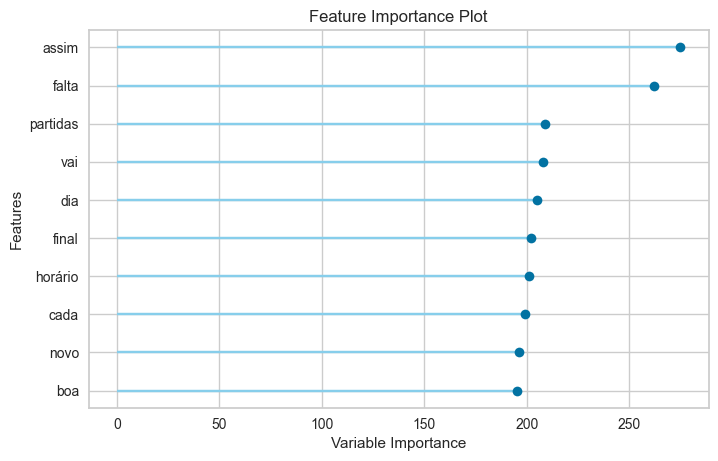

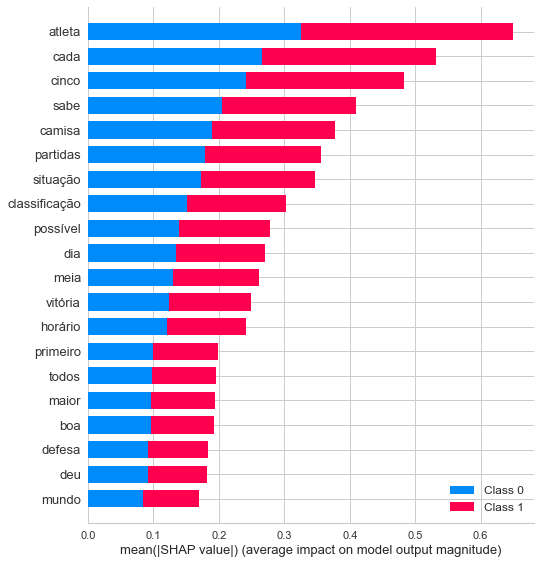

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
clf1 = setup(train_data_opt[features + [target]], target="target",
                       session_id=123, log_experiment=True, experiment_name="exp1",
            silent=True)

#best_model = compare_models()

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

lgbm = create_model("lightgbm")

tuned_lgbm = tune_model(lgbm,
                        fold=5,
                        n_iter=50,
                        optimize="AUC")

plot_model(tuned_lgbm, plot="feature")
interpret_model(tuned_lgbm)

best = automl(optimize='AUC')
best

### Tuned RF

In [37]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [38]:
benchmark = tuned_rf

In [39]:
benchmark.fit(train_vectors.drop(columns=["year"]), train["target"].values)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [40]:
train["prediction_rf"] = benchmark.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(train[target], train["prediction_rf"])

0.9127640207101315

In [41]:
test["prediction_rf"] = benchmark.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(test[target], test["prediction_rf"])

0.8972967177301542

In [42]:
out_of_time["prediction_rf"] = benchmark.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction_rf"])

0.8206693775811191

### lgbm

In [43]:
tuned_lgbm

LGBMClassifier(bagging_fraction=0.9, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=26, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=160, n_jobs=-1, num_leaves=200, objective=None,
               random_state=123, reg_alpha=0.2, reg_lambda=0.005, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [44]:
benchmark = tuned_lgbm
benchmark.fit(train_vectors.drop(columns=["year"]), train["target"].values)
train["prediction_lgbm"] = benchmark.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(train[target], train["prediction_lgbm"]))

test["prediction_lgbm"] = benchmark.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(test[target], test["prediction_lgbm"]))

out_of_time["prediction_lgbm"] = benchmark.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(out_of_time[target], out_of_time["prediction_lgbm"]))

0.9978565455849954
0.939354737110155
0.8400686184796399


## Out of time

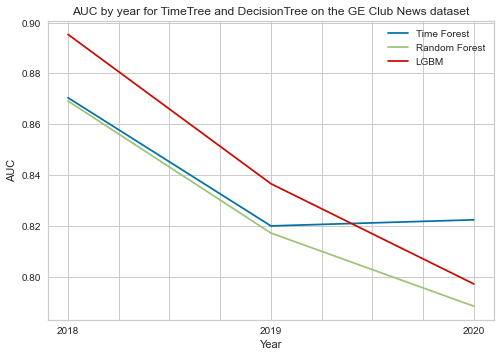

In [45]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

plt.legend()
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

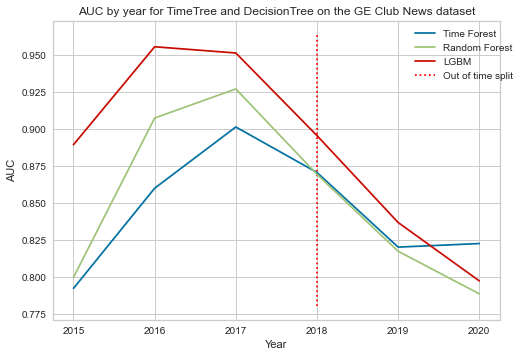

In [46]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

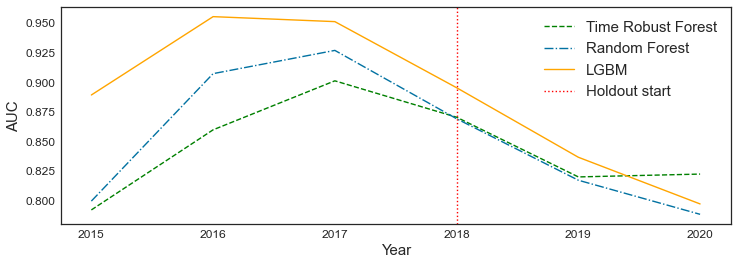

In [59]:
fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("images/ge_sklearn.eps", format="eps")
plt.show()